In [2]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import itertools

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
#from matplotlib.backends.backend_pdf import PdfPages

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points
from src.transpositions import Transposition
from src import poset_scores

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
def edges_cross(p1, p2, q1, q2):
    """Проверка, пересекаются ли отрезки (p1,p2) и (q1,q2)"""
    def ccw(a, b, c):
        return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
    
    return (ccw(p1, q1, q2) != ccw(p2, q1, q2)) and (ccw(p1, p2, q1) != ccw(p1, p2, q2))

def layout_is_planar(G, pos):
    """Проверяет, пересекаются ли ребра в данном расположении"""
    edges = list(G.edges())
    for (u1, v1), (u2, v2) in itertools.combinations(edges, 2):
        if len({u1, v1, u2, v2}) < 4:
            continue  # общая вершина, не может быть пересечения
        if edges_cross(pos[u1], pos[v1], pos[u2], pos[v2]):
            return False
    return True

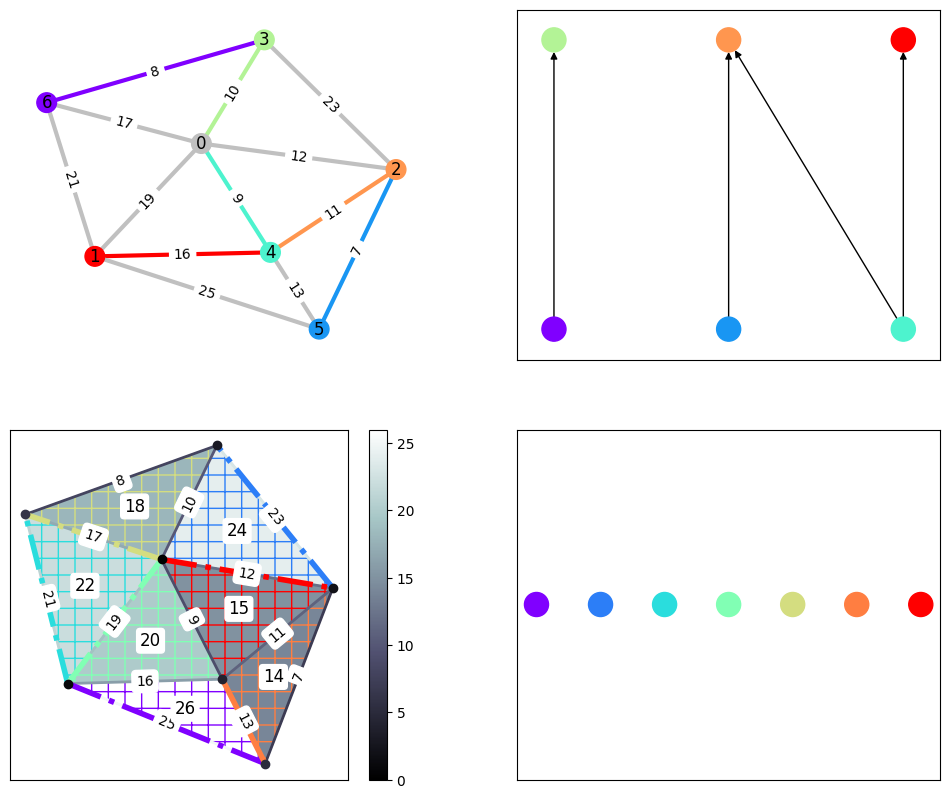

In [5]:
n = 7
points = np.random.random([n, 2])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
stree = gh.SimplexTree()
for value, simplex in enumerate(simplices):
    stree.insert(simplex, filtration=value)


dp = DepthPoset.from_simplex_tree(stree)
dp0 = dp.subposet_dim(0)
dp0_node_colors = plt.get_cmap('rainbow')(np.linspace(0, 1, len(dp0.nodes)))


stree_vertex_lebels = {}
stree_edge_labels = {}
for simplex, value in stree.get_filtration():
    if len(simplex) == 1:
        stree_vertex_lebels.update({simplex[0]: int(value)})
    if len(simplex) == 2:
        stree_edge_labels.update({tuple(simplex): int(value)})
stree_vertex_lebels = pd.Series(stree_vertex_lebels)
stree_edge_labels = pd.Series(stree_edge_labels)

stree_graph = nx.Graph()
stree_graph.add_nodes_from(stree_vertex_lebels.index)
stree_graph.add_edges_from(stree_edge_labels.index)

stree_vertex_colors = {node: 'silver' for node in stree_graph.nodes()}
stree_edge_colors = {edge: 'silver' for edge in stree_graph.edges()}
for node, color in zip(dp.nodes, dp0_node_colors):
    stree_vertex_colors

stree_vertex_colors = pd.Series(stree_vertex_colors)
stree_edge_colors = pd.Series(stree_edge_colors)

for node, color in zip(dp0.nodes, dp0_node_colors):
    node0 = node.source[0][0]
    node1 = tuple(node.source[1])
    stree_vertex_colors[node0] = color
    stree_edge_colors[node1] = color


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

pos = dict(enumerate(points))
pos = nx.kamada_kawai_layout(stree_graph, pos=pos)
if not layout_is_planar(stree_graph, pos):
    pos = dict(enumerate(points))

nx.draw(stree_graph, pos, with_labels=True, labels=stree_vertex_lebels, node_size=200, width=3, 
        node_color=stree_vertex_colors, edge_color=stree_edge_colors, ax=axs[0, 0])
nx.draw_networkx_edge_labels(stree_graph, pos=pos, edge_labels=dict(stree_edge_labels), ax=axs[0, 0])

nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.hasse_layout(), with_labels=False, node_color=dp0_node_colors, ax=axs[0, 1])



dp1 = dp.subposet_dim(1)
dp1_node_colors = plt.get_cmap('rainbow')(np.linspace(0, 1, len(dp1.nodes)))
nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.hasse_layout(), with_labels=False, node_color=dp1_node_colors, ax=axs[1, 1])


repoints = np.array(list(pos.values()))
sm = plot_filtred_complex2d(stree, points=repoints, cmap='bone', ax=axs[1, 0])
plt.colorbar(sm, ax=axs[1, 0])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

for node, color in zip(dp1.nodes, dp1_node_colors):
    cell0, cell1 = node.source
    plot_simplex(list(cell0), repoints, color, linestyle='-.', linewidth=4, ax=axs[1, 0])
    plot_simplex(list(cell1), repoints, color, linestyle=':', hatch='+', linewidth=1, ax=axs[1, 0])
nx.draw_networkx_edge_labels(stree_graph, pos=pos, edge_labels=dict(stree_edge_labels), ax=axs[1, 0])

simplices2 = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
values2 = np.array([value for simplex, value in stree.get_filtration()], dtype=int)
values2 = values2[np.vectorize(len)(simplices2) == 3]
simplices2 = simplices2[np.vectorize(len)(simplices2) == 3]
simplices2_pos = np.array([repoints[simplex].mean(axis=0) for simplex in simplices2])

for (x, y), val in zip(simplices2_pos, values2):
    axs[1, 0].text(x, y, str(val), fontsize=12, ha='center', va='center', 
                   bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2')
                   )

plt.show()

# 1-dimensional Barycentric

In [21]:
def plot_height_simplex(stree, simplex, ax=None, f=lambda t: np.sin(0.5*np.pi*t)**2, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    if len(simplex) == 1:
        x = simplex[0]
        y = stree.filtration(simplex)
        ax.scatter(x, y, **kwargs)
    elif len(simplex) == 2:
        x0 = simplex[0]
        x1 = np.mean(simplex)
        x2 = simplex[1]

        y0 = stree.filtration((simplex[0], ))
        y1 = stree.filtration(simplex)
        y2 = stree.filtration((simplex[1], ))
    
        t = np.linspace(0, 1)
        x = np.concatenate([x0*(1 - t) + x1*t, x1*(1 - t) + x2*t])
        y = np.concatenate([y0*f((1 - t)) + y1*f(t), y1*f((1 - t)) + y2*f(t)])
        ax.plot(x, y, **kwargs)

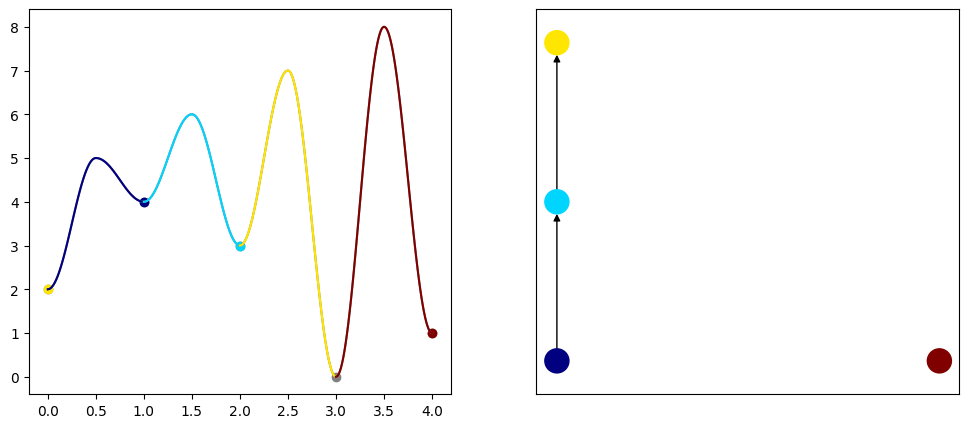

In [38]:
n = 5

values0 = np.random.choice(np.arange(n), n, replace=False)
values1 = n + np.random.choice(np.arange(n - 1), n - 1, replace=False)

stree = gh.SimplexTree()
for i, value in enumerate(values0):
    stree.insert([i], value)
for i, value in enumerate(values1):
    stree.insert([i, i+1], value)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

dp = DepthPoset.from_simplex_tree(stree)
node_colors = plt.get_cmap('jet')(np.linspace(0, 1, len(dp.nodes)))
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), node_color=node_colors, ax=axs[1], with_labels=False)

dp_cells0 = [tuple(node.source[0]) for node in dp.nodes]
dp_cells1 = [tuple(node.source[1]) for node in dp.nodes]

for simplex, value in stree.get_simplices():
    simplex = tuple(simplex)
    color = 'grey'
    plot_height_simplex(stree, simplex, color='grey', ax=axs[0])
    if simplex in dp_cells0:
        color = node_colors[dp_cells0.index(simplex)]
        plot_height_simplex(stree, simplex, color=color, ax=axs[0])
    if simplex in dp_cells1:
        color = node_colors[dp_cells1.index(simplex)]
        plot_height_simplex(stree, simplex, color=color, ax=axs[0])
